# Security Evaluation

How can the security of a machine learning model be truly evaluated?
Is one single $\epsilon$ enough?

In this notebook, you will use SecML to implement adversarial attacks against a given neural network, and we will reason on its robustness.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zangobot/teaching_material/blob/HEAD/02-SecurityEvaluations.ipynb)

In [9]:
try:
    import secml
except ImportError:
    %pip install git+https://github.com/pralab/secml
    %pip install foolbox

In [10]:
import torch
from torch import nn
from torch import optim
from secml.ml.classifiers import CClassifierPyTorch

random_state = 999


# creation of the multiclass classifier
class Net(nn.Module):
    def __init__(self, n_features, n_hidden, n_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


n_features = 2
n_classes = 3

# torch model creation
net = Net(n_features=n_features, n_classes=n_classes, n_hidden=100)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# wrap torch model in CClassifierPyTorch class
clf = CClassifierPyTorch(model=net,
                         loss=loss_function,
                         optimizer=optimizer,
                         input_shape=(n_features,),
                         random_state=random_state)

In [11]:
n_features = 2  # number of features
n_samples = 1250  # number of samples
centers = [[-2, 0], [2, -2], [2, 2]]  # centers of the clusters
cluster_std = 0.8  # standard deviation of the clusters
n_classes = len(centers)  # number of classes

from secml.data.loader import CDLRandomBlobs

dataset = CDLRandomBlobs(n_features=n_features,
                         centers=centers,
                         cluster_std=cluster_std,
                         n_samples=n_samples,
                         random_state=random_state).load()

n_tr = 1000  # number of training set samples
n_ts = 250  # number of test set samples

# split in training and test
from secml.data.splitter import CTrainTestSplit

splitter = CTrainTestSplit(
    train_size=n_tr, test_size=n_ts, random_state=random_state)
tr, ts = splitter.split(dataset)

# normalize the data
from secml.ml.features import CNormalizerMinMax

nmz = CNormalizerMinMax()
tr.X = nmz.fit(dataset.X).transform(tr.X)
ts.X = nmz.transform(ts.X)

In [12]:
clf.fit(tr.X, tr.Y)
y_pred = clf.predict(ts.X)

from secml.ml.peval.metrics import CMetricAccuracy

accuracy = CMetricAccuracy().performance_score(y_true=ts.Y, y_pred=y_pred)
print("Accuracy on test set: {:.2%}".format(accuracy))


Accuracy on test set: 99.60%


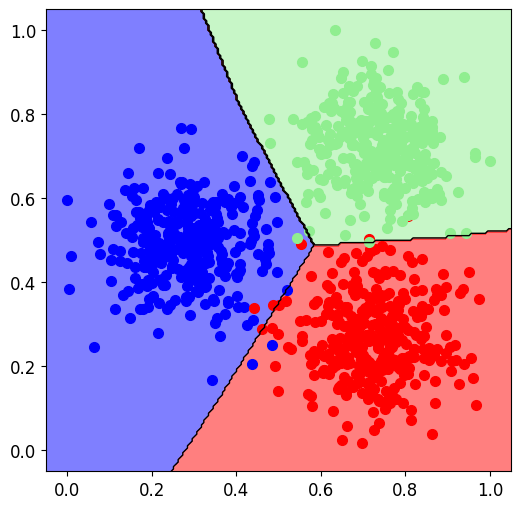

In [13]:
%matplotlib inline
from secml.figure import CFigure

fig = CFigure()
fig.sp.plot_ds(tr)
fig.sp.plot_decision_regions(clf, plot_background=True,
                             n_grid_points=200)
fig.show()

# Security Evaluations

Testing one single perturbation budget is not enough to understand the robustness of your machine learning classifier.
Hence, a fair analysis consists of a *security evaluation* of the model, by considering more perturbation budgets, and hence quantify the performance of the target systematically against stronger and stronger attacks.
To do so, we first set the number of parameters we want to test (in this case, `epsilons`) and we compute attacks by varying the perturbation size.

In [14]:
from secml.array import CArray
from secml.adv.attacks import CFoolboxPGDL2
from secml.ml.peval.metrics import CMetricAccuracy

epsilons = CArray.linspace(0,2,8) # create list of epsilons to use in the security evaluation
robust_accuracies = []
metric = CMetricAccuracy()
X, y = ts.X[:30, :], ts.Y[:30]

for eps in epsilons:
    pgd_attack = CFoolboxPGDL2(clf, None,
                           lb=0, ub=1,
                           epsilons=eps,
                           abs_stepsize=0.05,
                           steps=25,
                           random_start=False)
    y_adv_pred, _, _, _ = pgd_attack.run(X,y) # TODO: run the attack on the X, y set of samples
    accuracy = metric.performance_score(y, y_adv_pred)
    robust_accuracies.append(accuracy)

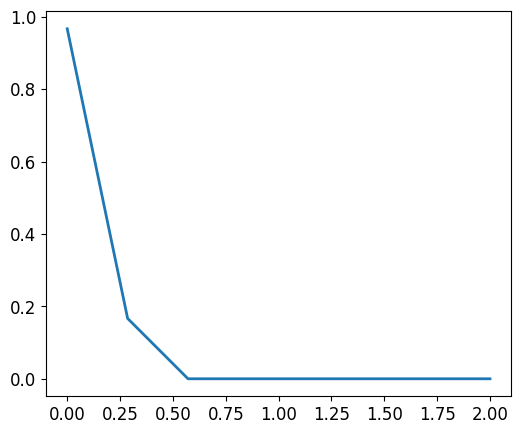

In [15]:
from secml.figure import CFigure

%matplotlib inline
fig = CFigure(height=5, width=6)
fig.sp.plot(epsilons, robust_accuracies)
fig.show()

# sampling not enough data gives me some problems? I really don't know. In reality data changes over time,
# so the test today gives me a result, tomorrow it will be different

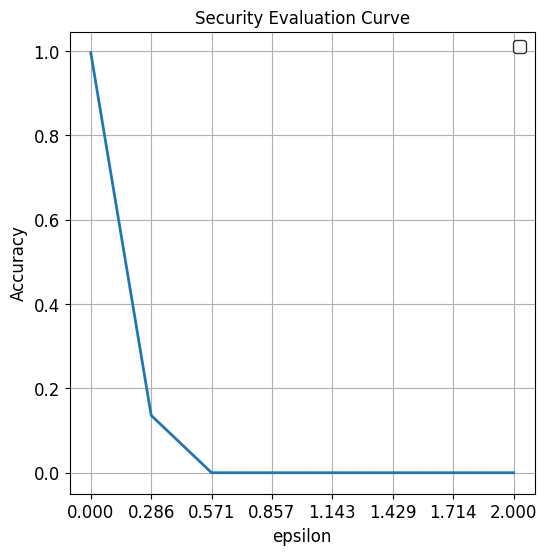

In [16]:
from secml.adv.seceval import CSecEval
pgd_attack = CFoolboxPGDL2(clf, None,
                           lb=0, ub=1,
                           epsilons=0,
                           abs_stepsize=0.05,
                           steps=20,
                           random_start=False)
sec_eval = CSecEval(pgd_attack, param_name='epsilon', param_values=epsilons)
sec_eval.run_sec_eval(ts)

%matplotlib inline
fig = CFigure()
fig.sp.plot_sec_eval(sec_eval.sec_eval_data)
fig.show()